conda activate phylo_placement

pip install Bio

In [5]:
import os
import pandas as pd
import numpy as np
from Bio import SeqIO
import json
from pathlib import Path

In [2]:
# import reference and test sequences
tob2 = SeqIO.to_dict(SeqIO.parse("../data/tob2_contigs.fasta", "fasta"))
ref = SeqIO.to_dict(SeqIO.parse("/home/tobamo/analize/project-tobamo/analysis/data/tobamo/reference_nukleotidne.fasta", 'fasta'))

In [3]:
# create outdir
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

### Rename sequences for EPA-ng/RAxML-ng compatibility

Special characters in sequence names can cause issues with EPA-ng and RAxML-ng. We'll create simple IDs (ref001, ref002, etc.) and maintain a mapper.

In [7]:
def create_simple_mapper(fasta_path, output_fasta, mapper_json, prefix="ref"):
    fasta_path = Path(fasta_path)
    output_fasta = Path(output_fasta)
    mapper_json = Path(mapper_json)
    
    # Create output directory if needed
    output_fasta.parent.mkdir(parents=True, exist_ok=True)
    mapper_json.parent.mkdir(parents=True, exist_ok=True)
    
    # Read sequences and create mapper
    mapper = {}
    renamed_records = []
    
    print(f"Reading sequences from: {fasta_path}")
    records = list(SeqIO.parse(fasta_path, "fasta"))
    print(f"Found {len(records)} sequences")
    
    for idx, record in enumerate(records, start=1):
        # Create simple ID
        simple_id = f"{prefix}{idx:03d}"
        
        # Store mapping
        mapper[simple_id] = {
            "original_id": record.id,
            "original_description": record.description
        }
        
        # Create renamed record (keep original in description for reference)
        new_record = record[:]  # Copy sequence
        new_record.id = simple_id
        new_record.name = simple_id
        new_record.description = ""  # Clean description to avoid issues
        renamed_records.append(new_record)
    
    # Write renamed FASTA
    print(f"Writing renamed FASTA to: {output_fasta}")
    SeqIO.write(renamed_records, output_fasta, "fasta")
    
    # Create reverse mapper for easy lookup
    reverse_mapper = {v["original_id"]: k for k, v in mapper.items()}
    
    full_mapper = {
        "simple_to_original": mapper,
        "original_to_simple": reverse_mapper,
        "metadata": {
            "total_sequences": len(records),
            "prefix": prefix,
            "input_file": str(fasta_path),
            "output_file": str(output_fasta)
        }
    }
    
    # Write mapper JSON
    print(f"Writing mapper to: {mapper_json}")
    with open(mapper_json, 'w') as f:
        json.dump(full_mapper, f, indent=2)
    
    print(f"\n✓ Success!")
    print(f"  - Renamed {len(records)} sequences")
    print(f"  - Output FASTA: {output_fasta}")
    print(f"  - Mapper JSON: {mapper_json}")
    
    return full_mapper

In [8]:
# Define paths
reference_fasta = "/home/tobamo/analize/project-tobamo/analysis/data/tobamo/reference_nukleotidne.fasta"
renamed_reference = "../data/reference_renamed.fasta"
mapper_file = "../data/reference_mapper.json"

# Create renamed FASTA and mapper
mapper = create_simple_mapper(
    fasta_path=reference_fasta,
    output_fasta=renamed_reference,
    mapper_json=mapper_file,
    prefix="ref"
)

# Show a few examples
print("\nExample mappings:")
for simple_id in list(mapper["simple_to_original"].keys())[:2]:
    original = mapper["simple_to_original"][simple_id]["original_id"]
    print(f"  {simple_id} → {original}")

Reading sequences from: /home/tobamo/analize/project-tobamo/analysis/data/tobamo/reference_nukleotidne.fasta
Found 125 sequences
Writing renamed FASTA to: data/reference_renamed.fasta
Writing mapper to: data/reference_mapper.json

✓ Success!
  - Renamed 125 sequences
  - Output FASTA: data/reference_renamed.fasta
  - Mapper JSON: data/reference_mapper.json

Example mappings:
  ref001 → X03854.1_Barley_stripe_mosaic_virus_(BSMV,_Type_strain)_genomic_RNA_beta
  ref002 → X14006.1_Pea_early_browning_virus_(PEBV)_genomic_RNA1_for_141K,_201K,_30K_and_12K_proteins
  ref003 → X03241.1_Tobacco_rattle_virus_RNA-2_(CAM_strain)_for_capsid_protein
  ref004 → X51828.1_Pea_early_browning_virus_complete_RNA2_genome_encoding_a_coat_protein_and_two_unidentified_reading_frames
  ref005 → J04342.1_Barley_stripe_mosaic_virus_alpha_RNA,_complete_cds


### TEMP

In [11]:
# Rename sequences in Newick tree file using the mapper
import json
import re

def rename_newick_tree(newick_file, mapper_json, output_file):
    """
    Replace original sequence IDs with simple IDs in a Newick tree file.
    
    Parameters:
    -----------
    newick_file : str
        Input Newick tree file
    mapper_json : str
        JSON file with sequence ID mappings
    output_file : str
        Output Newick tree file with renamed sequences
    """
    # Load mapper
    with open(mapper_json, 'r') as f:
        mapper_data = json.load(f)

    # Use original_id -> simple_id mapping
    mapping = mapper_data["original_to_simple"]

    # Read newick file
    print(f"Reading tree from: {newick_file}")
    with open(newick_file, 'r') as f:
        newick_content = f.read()

    # Replace each original ID with simple ID (sort by length to avoid partial replacements)
    replacements = 0
    for original_id in sorted(mapping.keys(), key=len, reverse=True):
        simple_id = mapping[original_id]
        if original_id in newick_content:
            newick_content = newick_content.replace(original_id, simple_id)
            replacements += 1

    # Write renamed tree
    print(f"Writing renamed tree to: {output_file}")
    with open(output_file, 'w') as f:
        f.write(newick_content)

    print(f"✓ Success! Replaced {replacements} sequence names")
    return replacements

# Example usage: replace original IDs with simple IDs in the tree file
newick_input = "results/ref_aligned.fasta.treefile"
newick_output = "results/ref_aligned_renamed.treefile"
mapper_json = "../data/reference_mapper.json"

rename_newick_tree(newick_input, mapper_json, newick_output)

Reading tree from: results/ref_aligned.fasta.treefile
Writing renamed tree to: results/ref_aligned_renamed.treefile
✓ Success! Replaced 11 sequence names


11

### create a reference tree

In [ ]:
mafft --auto --reorder /home/tobamo/analize/project-tobamo/analysis/phylogenetic_placement/data/reference_renamed.fasta > results2/mafft_aligned_refs_renamed.fasta

In [ ]:
iqtree3 -s results2/mafft_aligned_refs_renamed.fasta -m MFP -bb 1000 -T 38 --prefix results2/iqtree/ref_aligned

### create a query alignment

In [ ]:
mafft --auto --reorder /home/tobamo/analize/project-tobamo/analysis/phylogenetic_placement/data/tob2_contigs.fasta > results2/tob2_contigs_alignment.fasta

## EPA-ng v 0.3.8

In [ ]:
conda install -c bioconda epa-ng

inputs:

--ref-msa (.fasta)\
--tree (newick)\
--query (.fasta or .bfast)\
--outdir \
--model (model parameter specification)\
--threads (how many CPU)

epa-ng --ref-msa $REF_MSA --tree $TREE --query $QRY_MSA --model $MODEL

In [ ]:
# trying it the first time
epa-ng --ref-msa results2/mafft_aligned_refs_renamed.fasta --tree results2/iqtree/ref_aligned.treefile --model results2/iqtree/ref_aligned.model.qz --query ../data/tob2_contigs.fasta --threads 32 --redo

terminate called after throwing an instance of 'std::runtime_error'
  what():  Invalid model name: �

In [ ]:
# corrected model file extension
epa-ng --ref-msa results2/mafft_aligned_refs_renamed.fasta --tree results2/iqtree/ref_aligned.treefile --model results2/iqtree/ref_aligned.iqtree --query ../data/tob2_contigs.fasta --threads 32 --redo

continues! but another error:

terminate called after throwing an instance of 'std::runtime_error'\
  what():  ../data/tob2_contigs.fasta does not contain equal size sequences! First offending sequence: NODE_8049_length_1418_cov_3.901687_ERR1356733\
Aborted (core dumped)\

### query fasta must be an alignment fasta

In [ ]:
# changed --query input
epa-ng --ref-msa results2/mafft_aligned_refs_renamed.fasta --tree results2/iqtree/ref_aligned.treefile --model results2/iqtree/ref_aligned.iqtree --query results2/tob2_contigs_alignment.fasta --threads 32 --redo

The reference and query alignment files do not seem to have the same alignment width! (14280 vs. 10444). Are the query sequences not aligned?
Aborting with a failure.

EPA-ng requires the query alignment to have exactly the same column space (alignment width) as the reference MSA. Your query was aligned independently, so its width differs.

You must align the queries onto the existing reference alignment (not de-novo).\
Use MAFFT to add queries to the reference MSA:

For long contigs: use --add\
For short/fragmentary reads: use --addfragments

In [3]:
# check reference data length distribution and query lengths

tob2 = SeqIO.to_dict(SeqIO.parse("../data/tob2_contigs.fasta", "fasta"))
ref = SeqIO.to_dict(SeqIO.parse("/home/tobamo/analize/project-tobamo/analysis/data/tobamo/reference_nukleotidne.fasta", 'fasta'))

Length summary:
            count         mean          std     min     25%     50%     75%  \
set                                                                          
query      105.0  1276.142857   855.166858   606.0   717.0   876.0  1623.0   
reference  125.0  5369.432000  1546.463392  1799.0  3683.0  6311.0  6482.0   

              max  
set                
query      4942.0  
reference  7226.0   



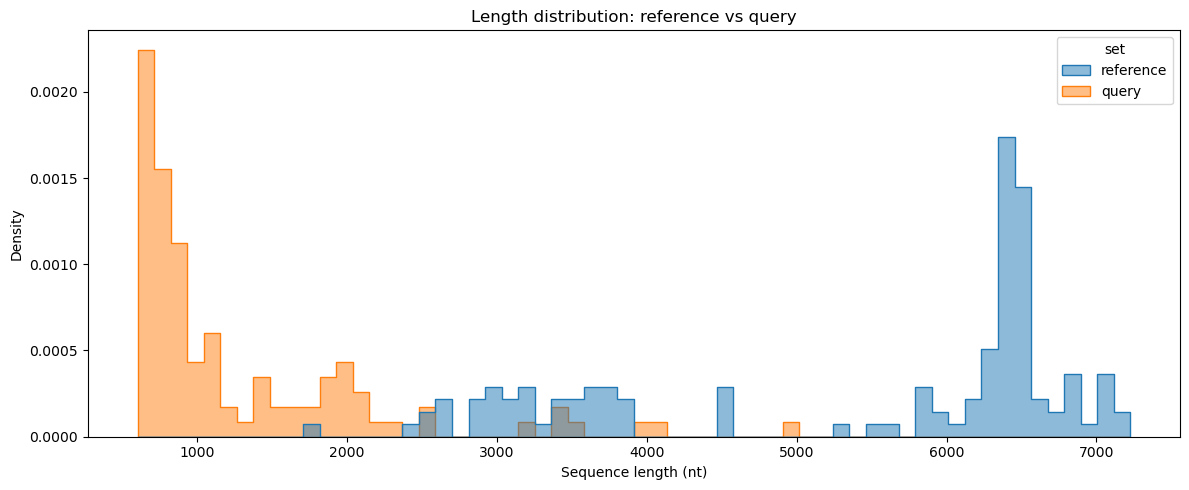

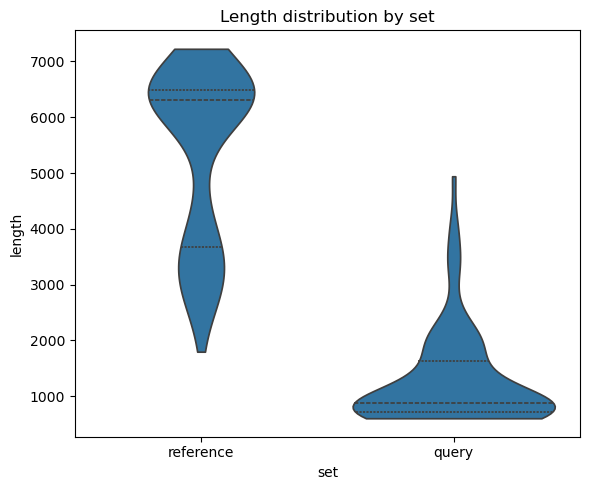

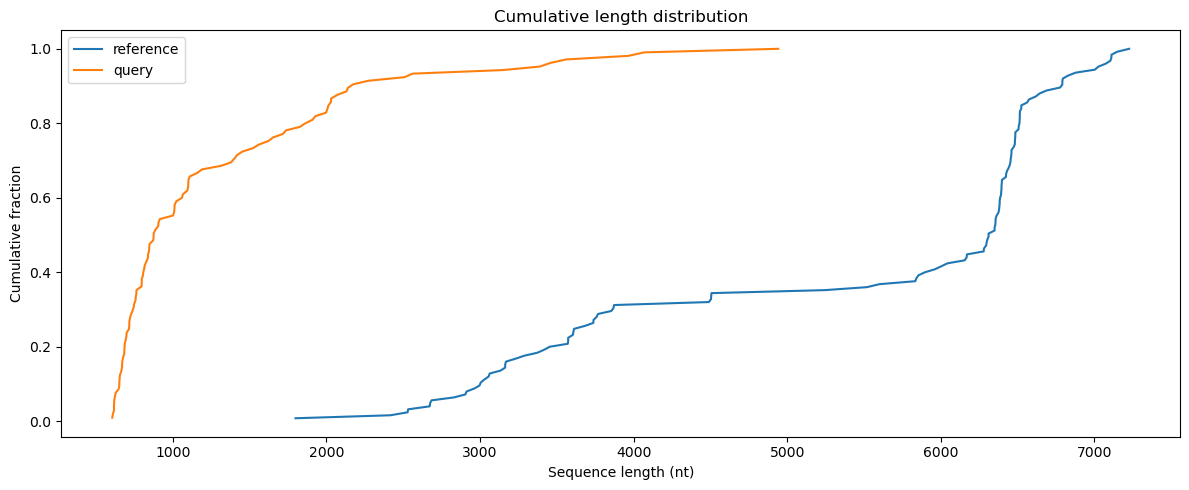

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Build DataFrame of lengths
ref_len = [len(rec.seq) for rec in ref.values()]
qry_len = [len(rec.seq) for rec in tob2.values()]

df = (
    pd.DataFrame({
        "length": ref_len + qry_len,
        "set": (["reference"] * len(ref_len)) + (["query"] * len(qry_len))
    })
)

# Basic summary
summary = df.groupby("set").length.describe()
print("Length summary:\n", summary, "\n")

# Plot distributions
plt.figure(figsize=(12,5))
sns.histplot(data=df, x="length", hue="set", element="step", bins=60, stat="density", common_norm=False, alpha=0.5)
plt.title("Length distribution: reference vs query")
plt.xlabel("Sequence length (nt)")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

# Box/violin for quick comparison
plt.figure(figsize=(6,5))
sns.violinplot(data=df, x="set", y="length", inner="quartile", cut=0)
plt.title("Length distribution by set")
plt.tight_layout()
plt.show()

# Cumulative distribution
plt.figure(figsize=(12,5))
for label, lengths in [("reference", ref_len), ("query", qry_len)]:
    arr = np.sort(lengths)
    cdf = np.arange(1, len(arr)+1) / len(arr)
    plt.plot(arr, cdf, label=label)
plt.title("Cumulative length distribution")
plt.xlabel("Sequence length (nt)")
plt.ylabel("Cumulative fraction")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Heuristic recommendation: --add vs --addfragments
import numpy as np
import statistics as stats

def recommend_add_mode(ref_lengths, qry_lengths, short_threshold=0.6, fragment_ratio=0.75):
    """
    Decide between MAFFT --add and --addfragments.

    Heuristics:
      1. Compute median length of reference (L_ref_med).
      2. Compute median length of queries (L_qry_med).
      3. If L_qry_med < short_threshold * L_ref_med -> candidates are shorter.
      4. Compute fraction of query seqs whose length < short_threshold * L_ref_med.
         If that fraction > fragment_ratio -> treat as fragments.

    Returns a tuple (mode, details_dict).
    """
    L_ref_med = stats.median(ref_lengths)
    L_qry_med = stats.median(qry_lengths)
    cutoff = short_threshold * L_ref_med
    frac_short = sum(l < cutoff for l in qry_lengths) / len(qry_lengths) if qry_lengths else 0
    mode = "--add"
    reason = "Query lengths broadly comparable to reference (not predominantly short)."
    if L_qry_med < cutoff and frac_short > fragment_ratio:
        mode = "--addfragments"
        reason = (f"Median query length ({L_qry_med:.1f}) < {short_threshold:.0%} of ref median ({L_ref_med:.1f}) "
                  f"and {frac_short:.1%} of queries are below that cutoff -> treating as fragments.")
    elif L_qry_med < cutoff:
        reason = (f"Median query length ({L_qry_med:.1f}) is shorter than cutoff {cutoff:.1f}, "
                  f"but only {frac_short:.1%} are that short (<= threshold); using regular --add.")
    details = {
        'ref_median': L_ref_med,
        'qry_median': L_qry_med,
        'cutoff': cutoff,
        'frac_short': frac_short,
        'short_threshold': short_threshold,
        'fragment_ratio_threshold': fragment_ratio,
        'reason': reason
    }
    return mode, details

mode, details = recommend_add_mode(ref_len, qry_len)
print("Recommendation:", mode)
print("Details:")
for k,v in details.items():
    print(f"  {k}: {v}")

Recommendation: --addfragments
Details:
  ref_median: 6311
  qry_median: 876
  cutoff: 3786.6
  frac_short: 0.9714285714285714
  short_threshold: 0.6
  fragment_ratio_threshold: 0.75
  reason: Median query length (876.0) < 60% of ref median (6311.0) and 97.1% of queries are below that cutoff -> treating as fragments.


#### MAFFT alignment choice
- Use `--add` when queries are roughly full-length like the reference sequences (not predominantly much shorter).
- Use `--addfragments` when most queries are shorter/fragmentary relative to the reference.

Example (adjust threads as needed):
- Add full-length queries:
  - `mafft --thread 32 --add ../data/tob2_contigs.fasta results2/mafft_aligned_refs_renamed.fasta > results2/ref_plus_query_aln.fasta`
- Add fragmentary queries:
  - `mafft --thread 32 --addfragments ../data/tob2_contigs.fasta results2/mafft_aligned_refs_renamed.fasta > results2/ref_plus_query_aln.fasta`


##namng issue, but it actually generates a reduced alignment with cleaned names \
/home/tobamo/analize/project-tobamo/analysis/phylogenetic_placement/epa-ng/results/info.raxml.reduced.phy

odownload and setup raxml-ng (see phylogenetic_placement/epa-ng/raxml-ng_setup.md)

In [ ]:
raxml-ng available at raxml-ng_v1.2.2/bin/raxml-ng --help

In [ ]:
raxml-ng_v1.2.2/bin/raxml-ng --evaluate --msa results/ref_aligned.fasta --tree results/ref_aligned.fasta.treefile --model GTR+G+F --prefix results/info

#naming issue, but it actually generates a reduced alignment with cleaned names \
/home/tobamo/analize/project-tobamo/analysis/phylogenetic_placement/epa-ng/results/info.raxml.reduced.phy

In [ ]:
raxml-ng_v1.2.2/bin/raxml-ng --evaluate \
  --msa results/info.raxml.reduced.phy \
  --tree results/ref_aligned.fasta.treefile \
  --model GTR+G+F \
  --prefix results/info